In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [4]:
data_fn='Yadkin_Creek.xlsx'

In [5]:
df=pd.read_excel(data_fn)

In [6]:
df2=pd.to_datetime(df[['year', 'month', 'day']])
df['time']=df2.values

In [7]:
df.head()

,year,month,day,Observed Runoff,Precipitation,Tmax,Tmin,Wind Speed,time
0,1950,6,1,2.47746,0.2576,30.6099,16.2888,0.8423,1950-06-01
1,1950,6,2,1.96266,5.4579,30.4237,18.1539,1.7568,1950-06-02
2,1950,6,3,1.96266,6.0343,28.3606,18.8719,2.1001,1950-06-03
3,1950,6,4,2.09136,10.5958,27.1970,18.6615,2.9097,1950-06-04
4,1950,6,5,1.89831,2.9596,24.1668,13.9388,1.0753,1950-06-05


In [8]:
def Runoff_Calc(df,initialQ,t):
    s='Q_'+str(t)
    df[s]=''
    df.loc[0,s]=df.loc[0,'Precipitation ']+(initialQ-df.loc[0,'Precipitation '])*np.exp(-1/t)
    for i in range(1,len(df)):
        df.loc[i,s]=df.loc[i,'Precipitation ']+(df.loc[i-1,s]-df.loc[i,'Precipitation '])*np.exp(-1/t)
    
    return df

In [9]:
def plot_fig(df,col1,col2,ylabel):
    fig=plt.figure()
    plt.plot(df.time,df[col1], color='red',label=col1)
    plt.plot(df.time,df[col2], color='green',label=col2)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.axhline(y=0)
    plt.legend()
    return fig

In [10]:
def calibarate_func(df,t,initialQ):
    df['cal']=''
    df.loc[0,'cal']=df.loc[0,'Precipitation ']+(initialQ-df.loc[0,'Precipitation '])*np.exp(-1/t)
    for i in range(1,len(df)):
        df.loc[i,'cal']=df.loc[i,'Precipitation ']+(df.loc[i-1,'cal']-df.loc[i,'Precipitation '])*np.exp(-1/t)
    figure=plot_fig(df,'Observed Runoff','cal','Runoff (mm/day)')    
    return df,figure

#### Assumption, initial Q=2.5

In [11]:
df_4=Runoff_Calc(df,2.5,4)
df_20=Runoff_Calc(df,2.5,20)

In [12]:
df_20.head()

,year,month,day,Observed Runoff,Precipitation,Tmax,Tmin,Wind Speed,time,Q_4,Q_20
0,1950,6,1,2.47746,0.2576,30.6099,16.2888,0.8423,1950-06-01,2.00398,2.39064
1,1950,6,2,1.96266,5.4579,30.4237,18.1539,1.7568,1950-06-02,2.76799,2.54023
2,1950,6,3,1.96266,6.0343,28.3606,18.8719,2.1001,1950-06-03,3.49049,2.71064
3,1950,6,4,2.09136,10.5958,27.1970,18.6615,2.9097,1950-06-04,5.06218,3.0952
4,1950,6,5,1.89831,2.9596,24.1668,13.9388,1.0753,1950-06-05,4.59709,3.08859


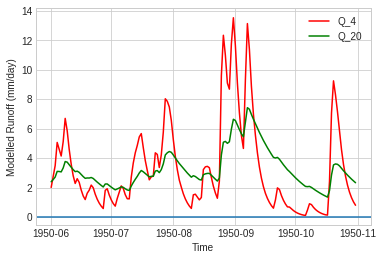

In [13]:
figure=plot_fig(df_20,'Q_4','Q_20','Modelled Runoff (mm/day)')

In [14]:
figure.savefig('1a.png', format='png', dpi=300)

In [15]:
df['Storage_4']=df.Q_4*4
df['Storage_20']=df.Q_20*20
mean_storage_4=df['Storage_4'].mean()
mean_storage_20=df['Storage_20'].mean()

In [16]:
mean_storage_4

13.23869970510527

In [17]:
mean_storage_20

65.85359519724571

In [18]:
mean_precip=df['Precipitation '].mean()

In [19]:
mean_precip

3.270408496732026

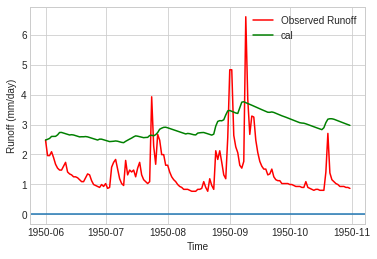

In [20]:
cal_df,figure1=calibarate_func(df_20,120,2.5)

In [21]:
figure1.savefig('1a_1.png',dpi=300,format='png')

## 1b) Evapotranspiration from inital reservoir model

### Assumption:- Change in amount of water stored is zero
#### ET=P-R

In [22]:
print ("sigmap",1)

sigmap 1


In [23]:
def func_uet(mp,mr,met,ci):
    if ci==95:
        z=1.96
    elif ci==90:
        z=1.643
    print("z",z)
    sigmap=(0.1*mp)/z
    sigmar=(0.05*mr)/z
    sigma_et=np.sqrt((sigmap**2)+(sigmar**2))
    uet=(z*sigma_et)/met
    et_max=met+(met*uet)
    et_min=met-(met*uet)
    print("sigma_p",sigmap)
    print("sigma_r",sigmar)
    print("sigma_et",sigma_et)
    print("uet",uet)
    print("et_min",et_min)
    print("et_max",et_max)
    return uet,et_max,et_min

##### For T*=4

In [38]:
#95% Confidence interval
mean_runoff_4=df_20['Q_4'].mean()
mean_ET_4=mean_precip-mean_runoff_4
print(mean_runoff_4)
print(mean_ET_4)
uet_4,et_max_4,et_min_4=func_uet(mean_precip,mean_runoff_4,mean_ET_4,95)


3.3096749262763177
-0.039266429544291714
1.96
0.1668575763638789
-9.334309756615461
-0.4057914459470275
0.32725858685844406


In [39]:
#90% Confidence interval
mean_runoff_4=df_20['Q_4'].mean()
mean_ET_4=mean_precip-mean_runoff_4
print(mean_runoff_4)
print(mean_ET_4)
uet_4,et_max_4,et_min_4=func_uet(mean_precip,mean_runoff_4,mean_ET_4,90)


3.3096749262763177
-0.039266429544291714
1.643
0.19905103449373257
-9.334309756615461
-0.4057914459470275
0.32725858685844406


##### For T*=20

In [40]:
#95% Confidence_Interval
mean_runoff_20=df_20['Q_20'].mean()
mean_ET_20=mean_precip-mean_runoff_20
print(mean_runoff_20)
print(mean_ET_20)
uet_20,et_max_20,et_min_20=func_uet(mean_precip,mean_runoff_20,mean_ET_20,95)

3.2926797598622852
-0.02227126313025929
1.96
0.1668575763638789
-16.44011562247415
-0.38841340405026753
0.34387087778974895


In [41]:
#90% Confidence_Interval
mean_runoff_20=df_20['Q_20'].mean()
mean_ET_20=mean_precip-mean_runoff_20
print(mean_runoff_20)
print(mean_ET_20)
uet_20,et_max_20,et_min_20=func_uet(mean_precip,mean_runoff_20,mean_ET_20,90)

3.2926797598622852
-0.02227126313025929
1.643
0.19905103449373257
-16.44011562247415
-0.38841340405026753
0.34387087778974895


##### Observed Runoff

In [24]:
#95% Confidence_Interval
mean_runoff=df_20['Observed Runoff'].mean()
mean_ET=mean_precip-mean_runoff
print(mean_runoff)
print(mean_ET)
uet,et_max,et_min=func_uet(mean_precip,mean_runoff,mean_ET,95)

1.461324522875817
1.809083973856209
z 1.96
sigma_p 0.1668575763638789
sigma_r 0.03727868680805656
sigma_et 0.17097120014833156
uet 0.18523382945924258
et_min 1.473980421565479
et_max 2.144187526146939


In [25]:
#90% Confidence_Interval
mean_runoff=df_20['Observed Runoff'].mean()
mean_ET=mean_precip-mean_runoff
print(mean_runoff)
print(mean_ET)
uet,et_max,et_min=func_uet(mean_precip,mean_runoff,mean_ET,90)

1.461324522875817
1.809083973856209
z 1.643
sigma_p 0.19905103449373257
sigma_r 0.04447122711125432
sigma_et 0.20395833979959208
uet 0.18523382945924252
et_min 1.4739804215654793
et_max 2.144187526146939


### 1c.) Linear reservoir Model using additional losses

In [26]:
df['I']=df['Precipitation ']-mean_ET

In [27]:
df.head()

,year,month,day,Observed Runoff,Precipitation,Tmax,Tmin,Wind Speed,time,Q_4,Q_20,Storage_4,Storage_20,cal,I
0,1950,6,1,2.47746,0.2576,30.6099,16.2888,0.8423,1950-06-01,2.00398,2.39064,8.01593,47.8127,2.48139,-1.551484
1,1950,6,2,1.96266,5.4579,30.4237,18.1539,1.7568,1950-06-02,2.76799,2.54023,11.0719,50.8046,2.50609,3.648816
2,1950,6,3,1.96266,6.0343,28.3606,18.8719,2.1001,1950-06-03,3.49049,2.71064,13.962,54.2127,2.53537,4.225216
3,1950,6,4,2.09136,10.5958,27.1970,18.6615,2.9097,1950-06-04,5.06218,3.0952,20.2487,61.904,2.60226,8.786716
4,1950,6,5,1.89831,2.9596,24.1668,13.9388,1.0753,1950-06-05,4.59709,3.08859,18.3884,61.7718,2.60523,1.150516


In [32]:
def Runoff_Calc_ET(df,initialQ,t):
    s='Q_'+str(t)
    df[s]=''
    df.loc[0,s]=df.loc[0,'I']+(initialQ-df.loc[0,'I'])*np.exp(-1/t)
    for i in range(1,len(df)):
        df.loc[i,s]=df.loc[i,'I']+(df.loc[i-1,s]-df.loc[i,'I'])*np.exp(-1/t)
    
    return df

In [33]:
df_ET_4=Runoff_Calc_ET(df,2.5,4)

In [34]:
df_ET_20=Runoff_Calc_ET(df_ET_4,2.5,27)

In [35]:
df_ET_20.head()

,year,month,day,Observed Runoff,Precipitation,Tmax,Tmin,Wind Speed,time,Q_4,Q_20,Storage_4,Storage_20,cal,I,Q_27
0,1950,6,1,2.47746,0.2576,30.6099,16.2888,0.8423,1950-06-01,1.60381,2.39064,8.01593,47.8127,2.48139,-1.551484,2.35269
1,1950,6,2,1.96266,5.4579,30.4237,18.1539,1.7568,1950-06-02,2.05617,2.54023,11.0719,50.8046,2.50609,3.648816,2.39982
2,1950,6,3,1.96266,6.0343,28.3606,18.8719,2.1001,1950-06-03,2.53596,2.71064,13.962,54.2127,2.53537,4.225216,2.46619
3,1950,6,4,2.09136,10.5958,27.1970,18.6615,2.9097,1950-06-04,3.91862,3.0952,20.2487,61.904,2.60226,8.786716,2.696
4,1950,6,5,1.89831,2.9596,24.1668,13.9388,1.0753,1950-06-05,3.30632,3.08859,18.3884,61.7718,2.60523,1.150516,2.63981


In [36]:
print(df_ET_20['Q_4'].min())
print(df_ET_20['Q_27'].min())

-1.7055402360609988
0.020794526745848474


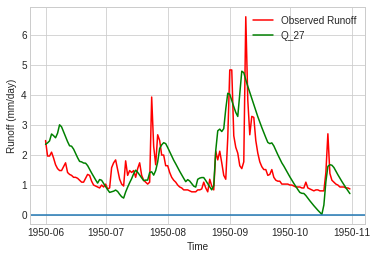

In [37]:
figure3=plot_fig(df_ET_20,'Observed Runoff','Q_27','Runoff (mm/day)')

In [38]:
def calibarate_func_ET(df,t,initialQ):
    df['cal']=''
    df.loc[0,'cal']=df.loc[0,'I']+(initialQ-df.loc[0,'I'])*np.exp(-1/t)
    for i in range(1,len(df)):
        df.loc[i,'cal']=df.loc[i,'I']+(df.loc[i-1,'cal']-df.loc[i,'I'])*np.exp(-1/t)
    figure=plot_fig(df,'Observed Runoff','cal','Runoff (mm/day)')    
    return df,figure

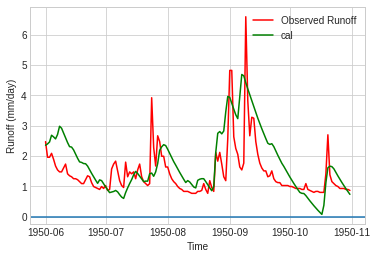

In [39]:
df_cal_ET,figure4=calibarate_func_ET(df_ET_20,28,2.5)

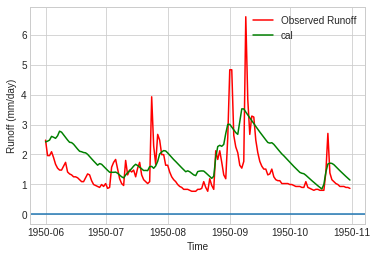

In [42]:
df_cal_ET,figure5=calibarate_func_ET(df_ET_20,50,2.5)

In [43]:
figure4.savefig('1c_1.png',dpi=300,format='png')
figure5.savefig('1c_2.png',dpi=300,format='png')


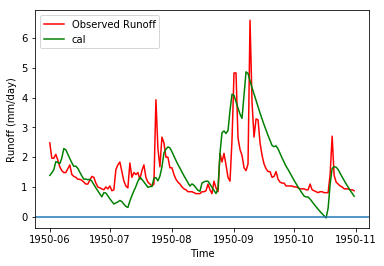

In [209]:
df_cal_ET,figure6=calibarate_func_ET(df_ET_20,26,1.5)

In [210]:
figure6.savefig('1c_3.png',dpi=300,format='png')

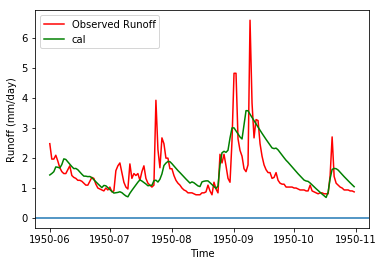

In [207]:
df_cal_ET,figure7=calibarate_func_ET(df_ET_20,45,1.5)

In [211]:
figure7.savefig('1c_4.png',dpi=300,format='png')

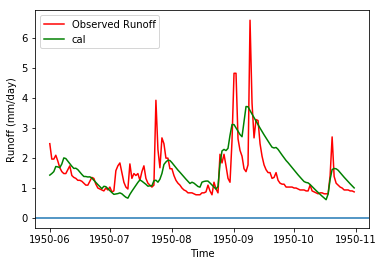

In [212]:
df_cal_ET,figure7=calibarate_func_ET(df_ET_20,42,1.5)

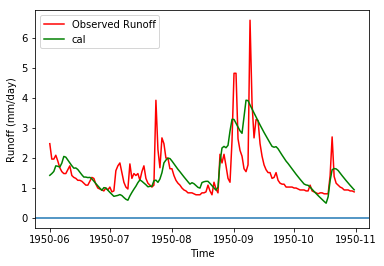

In [214]:
df_cal_ET,figure7=calibarate_func_ET(df_ET_20,38,1.5)